In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from myDataSet import *
from myNetworks import *
from myUtil import *
from tqdm import tqdm

In [2]:
# TODO: Implement GPU memory alloc in case of CUDA
# TODO: enable parallel GPU computation

In [2]:
# Set up the dataset.
image_directory = "Insects"
annotations_file_directory = "insects.csv"
dataset = MyCustomImageDataset(annotations_file_directory, image_directory)


# Preparing data for learning (normalization, one-hot encoding and batching)
my_batch_size, my_data_fraction, my_test_fraction = 4, 0.07, 0.3
prepped_data = DataPrep(dataset=dataset,
                        batch_size=my_batch_size,
                        data_fraction=my_data_fraction,
                        test_fraction=my_test_fraction)
prepped_data.prepare()
my_X_train_batches, my_Y_train_batches = prepped_data.train_X, prepped_data.train_Y
my_X_test_batches, my_Y_test_batches = prepped_data.test_X, prepped_data.test_Y
print("Shape of single batch: ",my_X_train_batches[0].shape)
print("my_X_test_batches: ", len(my_X_test_batches))

Initial nr. of batches:  181
Final nr. of batches:  12
Shape of single batch:  torch.Size([4, 3, 520, 520])
my_X_test_batches:  3


In [4]:
# Creating instance of neural network
my_nr_channels = my_X_train_batches[0].shape[1]
my_nr_classes = my_Y_train_batches[0].shape[1]
my_input_dimensions = (my_X_train_batches[0].shape[2], my_X_train_batches[0].shape[3])

my_net = NeuralNet2(channels_in=my_nr_channels,
                   nr_classes=my_nr_classes,
                   input_dimensions=my_input_dimensions)

In [5]:
train_accuracies, train_losses, test_accuracies, test_losses = my_net.train_network(
                                                        train_data_batches=my_X_train_batches,
                                                      train_labels_batches=my_Y_train_batches,
                                                         test_data_batches=my_X_test_batches,
                                                       test_labels_batches=my_Y_test_batches,
                                                                    epochs=6,
                                                               device_name='cpu')

 17%|█▋        | 1/6 [00:08<00:42,  8.42s/it]

Model saved at epoch:  1 , with test acc:  22.22222238779068 %


 33%|███▎      | 2/6 [00:16<00:33,  8.44s/it]

Model saved at epoch:  2 , with test acc:  27.77777910232544 %


 67%|██████▋   | 4/6 [00:33<00:16,  8.50s/it]

Model saved at epoch:  4 , with test acc:  30.55555522441864 %


100%|██████████| 6/6 [00:51<00:00,  8.50s/it]


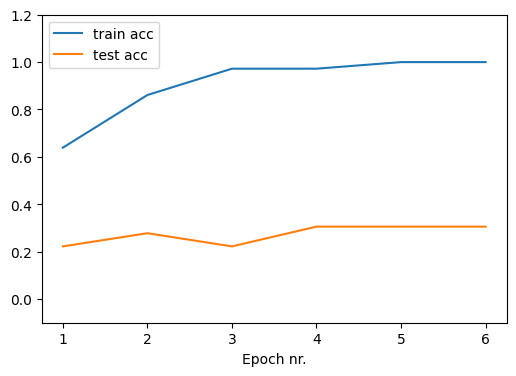

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
epochs = [i+1 for i in range(len(train_accuracies))]
ax.plot(epochs,train_accuracies,label="train acc")
#ax.plot(epochs,train_losses,label="train loss")
ax.plot(epochs,test_accuracies,label="test acc")
#ax.plot(epochs,test_losses,label="test loss")
ax.set_ylim(-0.1,1.2)
ax.set_xlabel("Epoch nr.")
ax.legend()
plt.show()

In [10]:
test_model(my_net,prepped_data,3)


 ---  Random Batch:  1  ---
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Panurgus banksianus  |--| Actual:  Panurgus banksianus  |##

 ---  Random Batch:  2  ---
  ##| Prediction:  Andrena fulva  |--| Actual:  Andrena fulva  |##
  ##| Prediction:  Andrena fulva  |--| Actual:  Andrena fulva  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##

 ---  Random Batch:  3  ---
  ##| Prediction:  Lasioglossum punctatissimum  |--| Actual:  Lasioglossum punctatissimum  |##
  ##| Prediction:  Andrena fulva  |--| Actual:  Panurgus banksianus  |##
  ##| Prediction:  Andrena fulva  |--| Actual:  Andrena fulva  |##
  ##| 

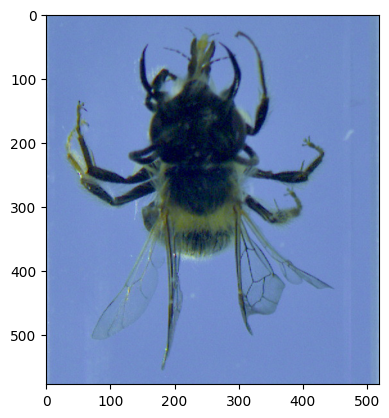

In [3]:
path = "Insects/1_003299_1_2020_05_05-10-57-38-916.jpg"
show_image_from_path(path)


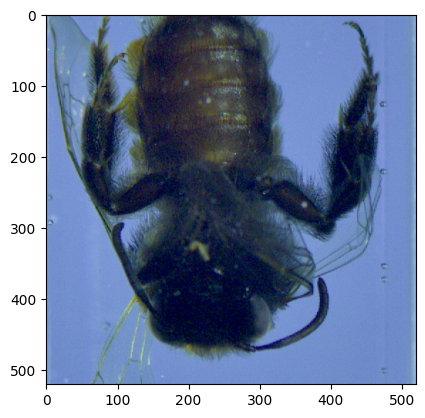

In [7]:
indx = 12
show_image_from_idx(index=indx,
                    dataset=dataset,
                    crop=True)

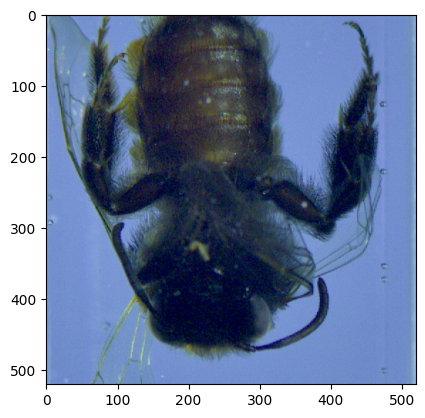

In [8]:
show_image_from_idx(index=indx,
                    dataset=dataset,
                    crop=False)